# Mobile Carrier Plan Suggestion

## Introduction

In this project we aim to train a prediction model to suggest a mobile carrier plan based on user behaviour for the Megaline Company. The data provided is user behavior for multiples users of Megaline Company, and their respective current plan. No additional information to define ideal usage of plans according to the company's perspective, only existing data about users. In advance, it can be stated that the model will mostly contribute to keeping historical user behavior, instead of being fine tuned to promote the company's ideal user behavior when suggesting plans directly to the user. After realizing preprocessing and data exploration, a Random Forest Classifier has been trained, validated and tested, requiring the needs of the user regarding telephone calls, text messages and internet traffic.


## Data Preprocess

### Objective

A single dataset has been provided, containing number of calls, durations in minutes, number of text messages and internet data and what plan does the user take: Ultra or Smart. It is important to note that no information on prices and ideal user for each plan has been provided, such that the final model will favor user behavior patterns rather than Megaline's requirements.


The first step is to explore data and validate information. Data often comes with a few unpredicted issues, and these will be fixed in this preprocessing section.  These can include missing values, artifacts and incorrect data types. We will take a first look at the data and the information available while making sure the values are correctly loaded: numeric data should correctly be assigned as integer or float, corresponding to their values. At the end of this section, we expect to have data ready for analysis and the drawing of results.

### Code

In [395]:
import pandas as pd

path_array = ['', '/', '/datasets/', './datasets/', '../datasets/']
CSVPATH = None

for i in path_array:
    try:
        pd.read_csv(i + 'users_behavior.csv', nrows=1)
        CSVPATH = i
    except:
        pass

if CSVPATH:
    print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)
else:
    print('No path found')

Path found is ../datasets/


In [396]:
def optimize_types(df):
    df_dtypes = df.dtypes
    df_names = df.index
    df_types = [i.name for i in df_dtypes.values]
    df_types = dict(zip(df_names, df_types))
    return df_types

In [397]:
df = pd.read_csv(CSVPATH + 'users_behavior.csv', nrows=50)

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [398]:
float_columns = [x for x in list(df.columns) if x not in ['calls', 'is_ultra']]

for col in float_columns:
    df[col] = pd.to_numeric(df[col], downcast = 'float')

df['calls'] = pd.to_numeric(df['calls'], downcast='integer')

df['is_ultra'] = df['is_ultra'].astype('uint8')

df_types = optimize_types(df)

df = pd.read_csv(
    CSVPATH+'users_behavior.csv', 
    dtype=df_types)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int16
minutes     3214 non-null float32
messages    3214 non-null float32
mb_used     3214 non-null float32
is_ultra    3214 non-null uint8
dtypes: float32(3), int16(1), uint8(1)
memory usage: 47.2 KB


,calls,minutes,messages,mb_used,is_ultra
0,40,311.899994,83.0,19915.419922,0
1,85,516.750000,56.0,22696.960938,0
2,77,467.660004,86.0,21060.449219,0
3,106,745.530029,81.0,8437.389648,1
4,66,418.739990,1.0,14502.750000,0


In [399]:
print(f'Number of duplicated rows: {df[df.duplicated()].shape[0]}')

Number of duplicated rows: 0


In [400]:
from IPython.display import display

display(df.describe().round(2))

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.57,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.23,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


### Results

Data has been loaded with optimized data types and no issues were found regarding missing values and duplicates. Next, we will take a look at the distributions and prepare our datasets for model training.


## Exploratory Data Analysis



### Objective


In this section, we will plot histograms of data and check the progressions for each plan, so we can have a general understanding of the information before training the plan suggestions model. A scatterplot matrix should be plotted beforehand to check the correlations and what factors can affect our suggestions on user plans.


### Code

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


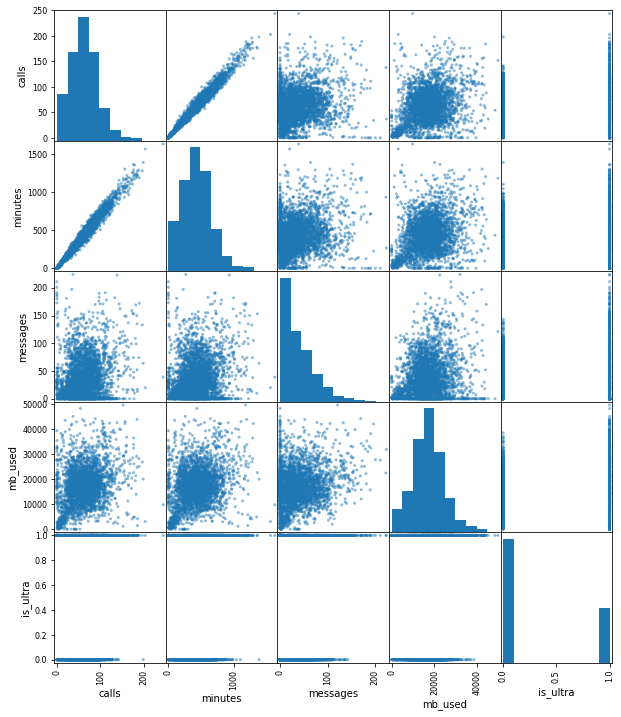

In [401]:
import matplotlib.pyplot as plt

display(df.corr())
pd.plotting.scatter_matrix(df, figsize=(10, 12))
plt.show()

*Graph Analysis*

By looking at the scatter matrix plot, we can see that internet traffic, messages, calls and total duration in minutes are generally proportional to each other. However, none of them have some special correlation with the plan: all of the correlation coefficients are around 0.20. This implies that it isn't such an easy task to correctly predict the user plan based on behavior, as the data of ultra plan customers is heterogenous.

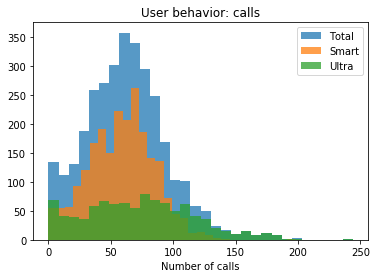

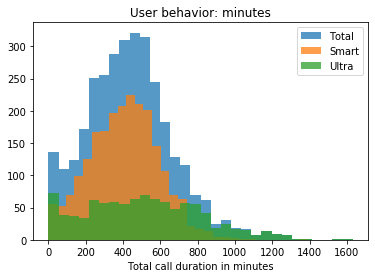

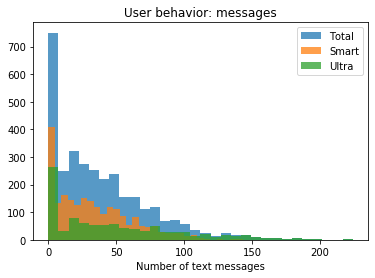

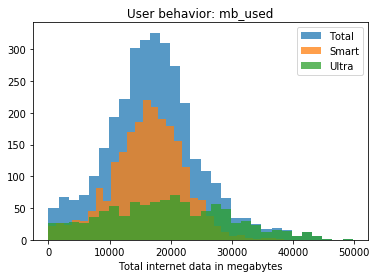

In [402]:
histogram_plots = [x for x in list(df.columns) if x != 'is_ultra']
x_labels = ['Number of calls', 'Total call duration in minutes', 'Number of text messages', 'Total internet data in megabytes', 'Metric']
y_labels = ['Amount']

ultra = df[df['is_ultra'] == True].reset_index(drop=True)

smart = df[df['is_ultra'] == False].reset_index(drop=True)

for col, x in zip(histogram_plots, x_labels) :
    plt.figure()
    plt.hist(df[col], bins=30, alpha=0.75)
    plt.hist(smart[col], bins=30, alpha=0.75)
    plt.hist(ultra[col], bins=30, alpha=0.75)
    plt.xlabel(x)
    plt.title(f'User behavior: {col}')
    plt.legend(['Total', 'Smart', 'Ultra'])

*Graph Analysis*


The histograms show us the distributions of each plan for each column of information provided. This histogram shows us how different are the values for each plan, and we can see that the distributions for ultra users are much more spread and slightly positive skewed. On the other hand, smart users tend to follow a bell-shaped distribution without much skew. In addition, the graph on messages by plans shows that many users do not use the service.

In [403]:
print('Ultra User Behavior Description')
display(ultra.describe().round(2))
print('\nSmart User Behavior Description')
smart.describe().round(2)

Ultra User Behavior Description


,calls,minutes,messages,mb_used,is_ultra
count,985.00,985.00,985.00,985.00,985.0
mean,73.39,511.22,49.36,19468.82,1.0
std,43.92,308.03,47.80,10087.18,0.0
min,0.00,0.00,0.00,0.00,1.0
25%,41.00,276.03,6.00,11770.28,1.0
50%,74.00,502.55,38.00,19308.01,1.0
75%,104.00,730.05,79.00,26837.72,1.0
max,244.00,1632.06,224.00,49745.73,1.0



Smart User Behavior Description


,calls,minutes,messages,mb_used,is_ultra
count,2229.00,2229.00,2229.00,2229.00,2229.0
mean,58.46,405.94,33.38,16208.47,0.0
std,25.94,184.51,28.23,5870.50,0.0
min,0.00,0.00,0.00,0.00,0.0
25%,40.00,274.23,10.00,12643.05,0.0
50%,60.00,410.56,28.00,16506.93,0.0
75%,76.00,529.51,51.00,20043.06,0.0
max,198.00,1390.22,143.00,38552.62,0.0


In [404]:
def split_df(df, train=3, valid=1, test=1):
    split_size = int(df.shape[0]/(train+valid+test))
    train_df = df[0 : train*split_size].reset_index(drop=True)
    valid_df = df[train*split_size+1 : (train+valid)*split_size].reset_index(drop=True)
    test_df = df[(train+valid)*split_size+1 : df.shape[0]].reset_index(drop=True)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)

print('Splitting dataframes in proportion: 3, 1, 1')
print('Train dataframe size:', train_df.shape[0])
print('Validation dataframe size:', valid_df.shape[0])
print('Test dataframe size:', test_df.shape[0])

Splitting dataframes in proportion: 3, 1, 1
Train dataframe size: 1926
Validation dataframe size: 641
Test dataframe size: 645


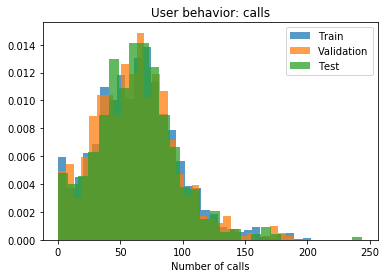

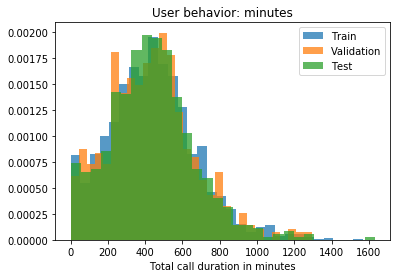

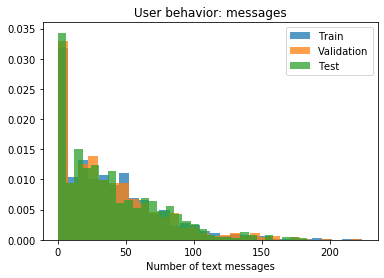

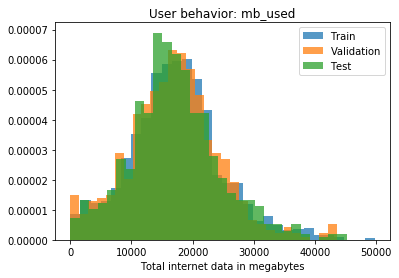

In [405]:
for col, x in zip(histogram_plots, x_labels) :
    plt.figure()
    plt.hist(train_df[col], bins=30, alpha=0.75,density=True)
    plt.hist(valid_df[col], bins=30, alpha=0.75, density=True)
    plt.hist(test_df[col], bins=30, alpha=0.75, density=True)
    plt.xlabel(x)
    plt.title(f'User behavior: {col}')
    plt.legend(['Train', 'Validation', 'Test'])

*Graph Analysis*

We have split our dataset in training, validation and test datasets for our prediction model. The proportion kept was 3:1:1, respectively. The histograms were plotted to check for data bias after splitting the original data. After checking these graphs, it seems like the three sets follow a regular pattern that reflects the curve of the overall data, suggesting that our sets are unbiased and correspondent to the user behavior provided for analysis.

### Results

We have taken a look at distributions of features for each plan, and the histograms show that the patterns between users are different enough for our model to succesfully tell them apart. We have also checked the correlation of features between themselves and the chosen plans, showing that no specific feature is defining when choosing a plan. On the other hand, calls and minutes are very correlated as expected, such that we could consider reducing the number of features to produce a model that requires less input.

## Model Training

### Objective

A machine learning model is a program trained by a computer to generate output (prediction) based on input (features), by identifying patterns of data to which it has been previously exposed. This program can be configured by changing the classification methods and its settings (hyperparameters) such as the intrinsic complexity of the program, as well as the data to which it has been exposed. These models can be classifiers or regressors that can predict categorical or numerical variables respectively.

Our objective is to produce a model that can predict a plan for a user of Megaline based on patterns of previous users, so we will be using classifiers. We expect to introduce features of users each at a time (observations), and receive predictions. We will try out reducing the number of features to get a succesfull model with the least number of information from the user. To accomplish that, we will try out a few different classifiers and tune them to get the most succesful result.

### Code

In [406]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

def target_features(df, tar_col, remove=['is_ultra']):
    target = df[tar_col]
    remove.append(tar_col)
    features = df[[x for x in train_df.columns.values if x not in remove]]
    return target, features

In [407]:
def find_level(model, param, level=10):
    best = {
        'i': -1, 
        'score': -1
    }
    for i in range(1, level+1):
        setattr(model, param, i)
        model.fit(train_feat, train_target)
        score = model.score(valid_feat, valid_target)
        if (score - best['score']) > 0.001:
            best['score'] = score
            best['i'] = i
    return best['score'], best['i']

def report(predictions, target):
    print('Accuracy:', metrics.accuracy_score(target,predictions))
    print('Recall:', metrics.recall_score(target,predictions))
    print('Precision:', metrics.precision_score(target,predictions))

In [408]:
# Features to remove, in order to simplify the input
remove_list = ['calls']
train_target, train_feat = target_features(train_df, 'is_ultra', remove_list)

valid_target, valid_feat = target_features(valid_df, 'is_ultra', remove_list)

test_target, test_feat = target_features(test_df, 'is_ultra', remove_list)

In [409]:
# Launching tree model and finding the ideal depth
tree_model = DecisionTreeClassifier(random_state=1995)

score, level = find_level(tree_model, 'max_depth', 100)

tree_model.max_depth = level
tree_model.fit(train_feat, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1995, splitter='best')

In [410]:
# Launching linear model
linear_model = LogisticRegression(solver='liblinear')

linear_model.fit(train_feat, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [411]:
# Launching forest model and finding ideal number of estimators
forest_model = RandomForestClassifier(max_leaf_nodes=10, random_state=1995, 
    class_weight={
        1: 2.25,
        0: 1
    }
    )

score, level = find_level(forest_model, 'n_estimators', 20)

forest_model.n_estimators = level
forest_model.fit(train_feat, train_target)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2.25},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=10, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=18, n_jobs=None, oob_score=False,
                       random_state=1995, verbose=0, warm_start=False)

In [412]:
tree_predict = tree_model.predict(test_feat)

print('Report of tree model:')
report(tree_predict, test_target)

Report of tree model:
Accuracy: 0.786046511627907
Recall: 0.4467005076142132
Precision: 0.7521367521367521


In [413]:
print('Report of logistic model:')
report(linear_model.predict(test_feat), test_target)

Report of logistic model:
Accuracy: 0.7116279069767442
Recall: 0.06598984771573604
Precision: 0.8666666666666667


In [414]:
print('Report of Random Forest model:')
report(forest_model.predict(test_feat), test_target)

Report of Random Forest model:
Accuracy: 0.8108527131782945
Recall: 0.700507614213198
Precision: 0.6865671641791045


In [415]:
print('Sanity check: when assigning ultra to all users')
report([1 for x in range(len(test_target))], test_target)

Sanity check: when assigning ultra to all users
Accuracy: 0.3054263565891473
Recall: 1.0
Precision: 0.3054263565891473


In [416]:
print('Sanity check: when assigning smart or ultra interchangeably')
report([0 if x%2 == 0 else 1 for x in range(len(test_target)) ], test_target)

Sanity check: when assigning smart or ultra interchangeably
Accuracy: 0.48372093023255813
Recall: 0.4720812182741117
Precision: 0.2888198757763975


In [417]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

print('Sanity check: when assigning smart to all users')
report([0 for x in range(len(test_target))], test_target)


Sanity check: when assigning smart to all users
Accuracy: 0.6945736434108527
Recall: 0.0
Precision: 0.0


In [418]:
print('Sanity check: when assigning ultra to 2/3 of users')
report([1 if x%3 == 0 else 0 for x in range(len(test_target)) ], test_target)

Sanity check: when assigning ultra to 2/3 of users
Accuracy: 0.5503875968992248
Recall: 0.3096446700507614
Precision: 0.2837209302325581


In [419]:
final_model = forest_model
importances = final_model.feature_importances_
print('The final model is a Random Forest model with 2 estimators. \nThe random state defined was 1995. \nInputs are: minutes, messages and megabytes used.\nThe importances of each feature, respectively, are', list(importances.round(2)), end='.\n\n')
report(final_model.predict(test_feat), test_target)

The final model is a Random Forest model with 2 estimators. 
The random state defined was 1995. 
Inputs are: minutes, messages and megabytes used.
The importances of each feature, respectively, are [0.34, 0.21, 0.45].

Accuracy: 0.8108527131782945
Recall: 0.700507614213198
Precision: 0.6865671641791045


In [420]:
import joblib

#dump(final_model, 'model.joblib')

OBS: Use the code line above to save the model.

### Results

We have succesfully come up with a model that can correctly predict more than 81% of the cases, while correctly identifying 70% of the Ultra users and assigning the Ultra plan for Smart users in 32% of the suggested Ultra plans. It requires as input a user's monthly needs in total call duration in minutes, number of text messages and megabytes used of internet traffic. The random forest model performed much better than the other classifiers, even with only 2 estimators. In fact, the number of estimators has been tested up to 100 estimators, and 2 estimators were enough to reach the best performance.

Sanity checks were made to confirm the results of our final model, considering that nearly 30% of the users are ultra users. The final model shows a much better result independetly.

## Conclusion

This document aimed to produce a trained machine learning model to identify the mobile carrier plans for Megaline Company. Our final model was able to reach 80% accuracy, with 80% recall and 50% precision. A higher precision means that most of the ultra plan users will be distinguished from smart users, while lower precision means more users will be suggested the ultra plan. The compromise between recall and precision can be fine tuned by restricting ultra predictions.

This model can be used to suggest user plans to new users according to their expected needs. This can either be used to reacher higher customer satisfaction rates, as well as for marketing of a plan over the other, according to the expectations of Megaline. For example, if the company would like more users to get to know the ultra plan, a lower precision means more users that marginally have smart plan behavior will be suggested the ultra plan and take look at the offers before choosing their plans.

Lastly, it is important to note that no information on ideal users of each plan has been provided as input data, such that the historical user behavior is the only factor considered when suggesting plans. Therefore, the model is most helpful in keeping the current user behavior, and it will not be as helpful if the company is not satisfacted with how users are choosing their plans.